<table class="table table-bordered">
    <tr>
        <th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 1 - Food Classification Model (Individual)</h2><h3>AY2023/24 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
import os
import numpy as np
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2

callback = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Step 1: Data Loading

In [2]:
img_size = 150
batch_size = 25 
base_dir = 'C:\\Users\\ryanl\\Downloads\\DL ASG'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

augmented_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

regular_generator = ImageDataGenerator(rescale=1./255)

# Data Generator Initialization
def load_images(directory, datagen):
    return datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical')

# Feature Extraction Function
def extract_features_from_generator(generator, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 1280))
    labels = np.zeros(shape=(sample_count, 10))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

# Training Set (Regular Data)
regular_train_generator = load_images(train_dir, regular_generator)

# Training Set (Augmented Data)
augmented_train_generator = load_images(train_dir, augmented_generator)

# Validation and Test Set
validation_generator = load_images(validation_dir, regular_generator)
test_generator = load_images(test_dir, regular_generator)

# Training Features and Labels (Regular Data)
regular_train_features, regular_train_labels = extract_features_from_generator(regular_train_generator, 7500)

# Training Features and Labels (Augmented Data)
augmented_train_features, augmented_train_labels = extract_features_from_generator(augmented_train_generator, 7500)

# Validation and Test Features and Labels
validation_features, validation_labels = extract_features_from_generator(validation_generator, 2000)
test_features, test_labels = extract_features_from_generator(test_generator, 500)

# Training Features array reshaping (Regular Data)
regular_train_features = np.reshape(regular_train_features, (7500, 5 * 5 * 1280))

# Training Features array reshaping (Augmented Data)
augmented_train_features = np.reshape(augmented_train_features, (7500, 5 * 5 * 1280))

# Validation and Test Features array reshaping
validation_features = np.reshape(validation_features, (2000, 5 * 5 * 1280))
test_features = np.reshape(test_features, (500, 5 * 5 * 1280))

Found 7500 images belonging to 10 classes.
Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
1/1 [==============================] - 0s 19ms/step


# Step 2:  Develop the Image Classification Models

## Model #1

### Model #1 (Base without Data Augmentation)

In [4]:
# Build the Model
scratch_base_model = models.Sequential()

# Convolutional Base
scratch_base_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
scratch_base_model.add(layers.MaxPooling2D((2, 2)))

scratch_base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
scratch_base_model.add(layers.MaxPooling2D((2, 2)))

scratch_base_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
scratch_base_model.add(layers.MaxPooling2D((2, 2)))

scratch_base_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
scratch_base_model.add(layers.MaxPooling2D((2, 2)))

scratch_base_model.add(layers.Flatten())

# Dense Layers
scratch_base_model.add(layers.Dense(512, activation='relu'))
scratch_base_model.add(layers.Dense(10, activation='softmax'))

# Model Compilation
scratch_base_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
scratch_base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [5]:
# Train the Model
scratch_base_history = scratch_base_model.fit(
    regular_train_generator,
    steps_per_epoch=regular_train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback, reduce_lr]
)

Epoch 1/100
300/300 [==============================] - 25s 79ms/step - loss: 1.9690 - accuracy: 0.2953 - val_loss: 1.7828 - val_accuracy: 0.3740 - lr: 1.0000e-04
Epoch 2/100
300/300 [==============================] - 23s 78ms/step - loss: 1.6573 - accuracy: 0.4269 - val_loss: 1.6533 - val_accuracy: 0.4140 - lr: 1.0000e-04
Epoch 3/100
300/300 [==============================] - 23s 78ms/step - loss: 1.4927 - accuracy: 0.4885 - val_loss: 1.5473 - val_accuracy: 0.4810 - lr: 1.0000e-04
Epoch 4/100
300/300 [==============================] - 23s 78ms/step - loss: 1.3898 - accuracy: 0.5275 - val_loss: 1.4635 - val_accuracy: 0.4945 - lr: 1.0000e-04
Epoch 5/100
300/300 [==============================] - 23s 78ms/step - loss: 1.2656 - accuracy: 0.5687 - val_loss: 1.4705 - val_accuracy: 0.5035 - lr: 1.0000e-04
Epoch 6/100
300/300 [==============================] - 23s 78ms/step - loss: 1.1706 - accuracy: 0.6032 - val_loss: 1.3718 - val_accuracy: 0.5345 - lr: 1.0000e-04
Epoch 7/100
300/300 [=======

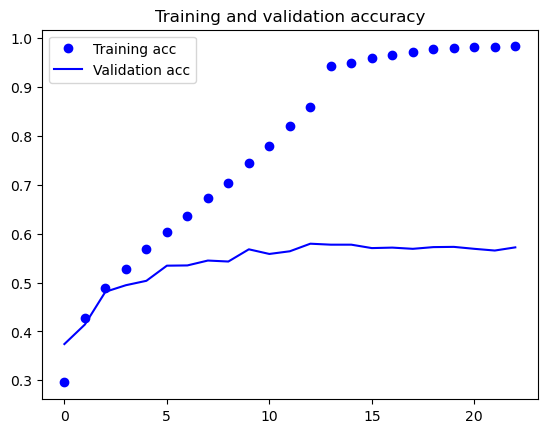

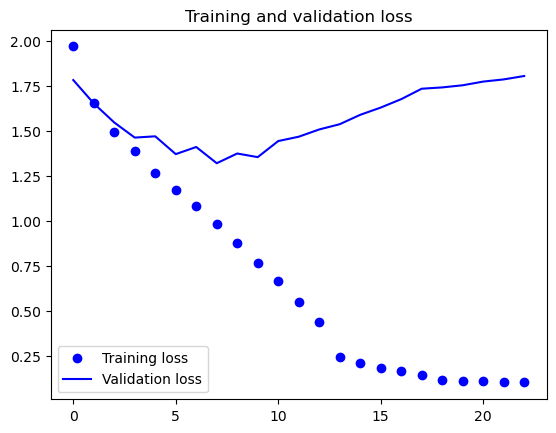

In [6]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

scratch_base_accuracy = scratch_base_history.history['accuracy']
scratch_base_val_accuracy = scratch_base_history.history['val_accuracy']
scratch_base_loss = scratch_base_history.history['loss']
scratch_base_val_loss = scratch_base_history.history['val_loss']

scratch_base_epochs = range(len(scratch_base_accuracy))

plt.plot(scratch_base_epochs, scratch_base_accuracy, 'bo', label='Training acc')
plt.plot(scratch_base_epochs, scratch_base_val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(scratch_base_epochs, scratch_base_loss, 'bo', label='Training loss')
plt.plot(scratch_base_epochs, scratch_base_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
# Save the Model
scratch_base_model.save('food_scratch_base_model_1.h5')

### Model #1 (Base with Data Augmentation)

In [12]:
scratch_augment_model = models.Sequential()

scratch_augment_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
scratch_augment_model.add(layers.MaxPooling2D((2, 2)))

scratch_augment_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
scratch_augment_model.add(layers.MaxPooling2D((2, 2)))

scratch_augment_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
scratch_augment_model.add(layers.MaxPooling2D((2, 2)))

scratch_augment_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
scratch_augment_model.add(layers.MaxPooling2D((2, 2)))

scratch_augment_model.add(layers.Flatten())

scratch_augment_model.add(layers.Dense(512, activation='relu'))
scratch_augment_model.add(layers.Dense(10, activation='softmax'))

scratch_augment_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

scratch_augment_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
# Train the Model
scratch_augment_history = scratch_augment_model.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback, reduce_lr]
)

Epoch 1/100
300/300 [==============================] - 44s 143ms/step - loss: 2.0377 - accuracy: 0.2577 - val_loss: 1.8063 - val_accuracy: 0.3680 - lr: 1.0000e-04
Epoch 2/100
300/300 [==============================] - 43s 142ms/step - loss: 1.8271 - accuracy: 0.3529 - val_loss: 1.6991 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 3/100
300/300 [==============================] - 45s 149ms/step - loss: 1.7300 - accuracy: 0.3919 - val_loss: 1.5942 - val_accuracy: 0.4565 - lr: 1.0000e-04
Epoch 4/100
283/300 [===========================>..] - ETA: 2s - loss: 1.6661 - accuracy: 0.4199

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

scratch_augment_accuracy = scratch_augment_history.history['accuracy']
scratch_augment_val_accuracy = scratch_augment_history.history['val_accuracy']
scratch_augment_loss = scratch_augment_history.history['loss']
scratch_augment_val_loss = scratch_augment_history.history['val_loss']

scratch_augment_epochs = range(len(scratch_augment_accuracy))

plt.plot(scratch_augment_epochs, scratch_augment_accuracy, 'bo', label='Training acc')
plt.plot(scratch_augment_epochs, scratch_augment_val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(scratch_augment_epochs, scratch_augment_loss, 'bo', label='Training loss')
plt.plot(scratch_augment_epochs, scratch_augment_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
scratch_augment_model.save('food_scratch_augment_model_1.h5')

### Model #1 (Increase Convolutional Filter Size)

In [ ]:
scratch_filter_model = models.Sequential()

scratch_filter_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
scratch_filter_model.add(layers.MaxPooling2D((2, 2)))

scratch_filter_model.add(layers.Conv2D(64, (5, 5), activation='relu'))
scratch_filter_model.add(layers.MaxPooling2D((2, 2)))

scratch_filter_model.add(layers.Conv2D(128, (7, 7), activation='relu'))
scratch_filter_model.add(layers.MaxPooling2D((2, 2)))

scratch_filter_model.add(layers.Conv2D(128, (9, 9), activation='relu'))
scratch_filter_model.add(layers.MaxPooling2D((2, 2)))

scratch_filter_model.add(layers.Flatten())

scratch_filter_model.add(layers.Dense(512, activation='relu'))
scratch_filter_model.add(layers.Dense(10, activation='softmax'))

scratch_filter_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

scratch_filter_model.summary()

In [ ]:
# Train the Model
scratch_filter_history = scratch_filter_model.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback, reduce_lr]
)

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

scratch_filter_accuracy = scratch_filter_history.history['accuracy']
scratch_filter_val_accuracy = scratch_filter_history.history['val_accuracy']
scratch_filter_loss = scratch_filter_history.history['loss']
scratch_filter_val_loss = scratch_filter_history.history['val_loss']

scratch_filter_epochs = range(len(scratch_filter_accuracy))

plt.plot(scratch_filter_epochs, scratch_filter_accuracy, 'bo', label='Training acc')
plt.plot(scratch_filter_epochs, scratch_filter_val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(scratch_filter_epochs, scratch_filter_loss, 'bo', label='Training loss')
plt.plot(scratch_filter_epochs, scratch_filter_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
scratch_filter_model.save('food_scratch_filter_model_1.h5')

### Model #1 (More Convolutional Layer Nodes)

In [ ]:
scratch_more_nodes_model = models.Sequential()

scratch_more_nodes_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
scratch_more_nodes_model.add(layers.MaxPooling2D((2, 2)))

scratch_more_nodes_model.add(layers.Conv2D(128, (5, 5), activation='relu'))
scratch_more_nodes_model.add(layers.MaxPooling2D((2, 2)))

scratch_more_nodes_model.add(layers.Conv2D(128, (7, 7), activation='relu'))
scratch_more_nodes_model.add(layers.MaxPooling2D((2, 2)))

scratch_more_nodes_model.add(layers.Conv2D(128, (9, 9), activation='relu'))
scratch_more_nodes_model.add(layers.MaxPooling2D((2, 2)))

scratch_more_nodes_model.add(layers.Flatten())

scratch_more_nodes_model.add(layers.Dense(512, activation='relu'))
scratch_more_nodes_model.add(layers.Dense(10, activation='softmax'))

scratch_more_nodes_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

scratch_more_nodes_model.summary()

In [ ]:
# Train the Model
scratch_more_nodes_history = scratch_more_nodes_model.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback, reduce_lr]
)

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

scratch_more_nodes_accuracy = scratch_more_nodes_history.history['accuracy']
scratch_more_nodes_val_accuracy = scratch_more_nodes_history.history['val_accuracy']
scratch_more_nodes_loss = scratch_more_nodes_history.history['loss']
scratch_more_nodes_val_loss = scratch_more_nodes_history.history['val_loss']

scratch_more_nodes_epochs = range(len(scratch_more_nodes_accuracy))

plt.plot(scratch_more_nodes_epochs, scratch_more_nodes_accuracy, 'bo', label='Training acc')
plt.plot(scratch_more_nodes_epochs, scratch_more_nodes_val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(scratch_more_nodes_epochs, scratch_more_nodes_loss, 'bo', label='Training loss')
plt.plot(scratch_more_nodes_epochs, scratch_more_nodes_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
scratch_more_nodes_model.save('food_scratch_more_nodes_model_1.h5')

### Model #1 (Dropout Layer)

In [ ]:
scratch_dropout_model = models.Sequential()

scratch_dropout_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
scratch_dropout_model.add(layers.MaxPooling2D((2, 2)))

scratch_dropout_model.add(layers.Conv2D(128, (5, 5), activation='relu'))
scratch_dropout_model.add(layers.MaxPooling2D((2, 2)))

scratch_dropout_model.add(layers.Conv2D(128, (7, 7), activation='relu'))
scratch_dropout_model.add(layers.MaxPooling2D((2, 2)))

scratch_dropout_model.add(layers.Conv2D(128, (9, 9), activation='relu'))
scratch_dropout_model.add(layers.MaxPooling2D((2, 2)))

scratch_dropout_model.add(layers.Flatten())

scratch_dropout_model.add(layers.Dropout(0.5))
scratch_dropout_model.add(layers.Dense(512, activation='relu'))
scratch_dropout_model.add(layers.Dropout(0.5))
scratch_dropout_model.add(layers.Dense(10, activation='softmax'))

scratch_dropout_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

scratch_dropout_model.summary()

In [ ]:
# Train the Model
scratch_dropout_history = scratch_dropout_model.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback, reduce_lr]
)

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

scratch_dropout_accuracy = scratch_dropout_history.history['accuracy']
scratch_dropout_val_accuracy = scratch_dropout_history.history['val_accuracy']
scratch_dropout_loss = scratch_dropout_history.history['loss']
scratch_dropout_val_loss = scratch_dropout_history.history['val_loss']

scratch_dropout_epochs = range(len(scratch_dropout_accuracy))

plt.plot(scratch_dropout_epochs, scratch_dropout_accuracy, 'bo', label='Training acc')
plt.plot(scratch_dropout_epochs, scratch_dropout_val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(scratch_dropout_epochs, scratch_dropout_loss, 'bo', label='Training loss')
plt.plot(scratch_dropout_epochs, scratch_dropout_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
scratch_dropout_model.save('food_scratch_dropout_model_1.h5')

### Model #1 (Global Average Pooled)

In [ ]:
scratch_gap_model = models.Sequential()

scratch_gap_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
scratch_gap_model.add(layers.MaxPooling2D((2, 2)))

scratch_gap_model.add(layers.Conv2D(128, (5, 5), activation='relu'))
scratch_gap_model.add(layers.MaxPooling2D((2, 2)))

scratch_gap_model.add(layers.Conv2D(128, (7, 7), activation='relu'))
scratch_gap_model.add(layers.MaxPooling2D((2, 2)))

scratch_gap_model.add(layers.Conv2D(128, (9, 9), activation='relu'))
scratch_gap_model.add(layers.MaxPooling2D((2, 2)))

scratch_gap_model.add(layers.GlobalAveragePooling2D())

scratch_gap_model.add(layers.Dropout(0.5))
scratch_gap_model.add(layers.Dense(512, activation='relu'))
scratch_gap_model.add(layers.Dropout(0.5))
scratch_gap_model.add(layers.Dense(10, activation='softmax'))

scratch_gap_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

scratch_gap_model.summary()

In [ ]:
# Train the Model
scratch_gap_history = scratch_gap_model.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback, reduce_lr]
)

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

scratch_gap_accuracy = scratch_gap_history.history['accuracy']
scratch_gap_val_accuracy = scratch_gap_history.history['val_accuracy']
scratch_gap_loss = scratch_gap_history.history['loss']
scratch_gap_val_loss = scratch_gap_history.history['val_loss']

scratch_gap_epochs = range(len(scratch_gap_accuracy))

plt.plot(scratch_gap_epochs, scratch_gap_accuracy, 'bo', label='Training acc')
plt.plot(scratch_gap_epochs, scratch_gap_val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(scratch_gap_epochs, scratch_gap_loss, 'bo', label='Training loss')
plt.plot(scratch_gap_epochs, scratch_gap_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
scratch_gap_model.save('food_scratch_gap_model_1.h5')

### Model #1 (Batch Normalized)

In [ ]:
scratch_normalized_model = models.Sequential()

scratch_normalized_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
scratch_normalized_model.add(BatchNormalization())
scratch_normalized_model.add(layers.MaxPooling2D((2, 2)))

scratch_normalized_model.add(layers.Conv2D(128, (5, 5), activation='relu'))
scratch_normalized_model.add(BatchNormalization())
scratch_normalized_model.add(layers.MaxPooling2D((2, 2)))

scratch_normalized_model.add(layers.Conv2D(128, (7, 7), activation='relu'))
scratch_normalized_model.add(BatchNormalization())
scratch_normalized_model.add(layers.MaxPooling2D((2, 2)))

scratch_normalized_model.add(layers.Conv2D(128, (9, 9), activation='relu'))
scratch_normalized_model.add(BatchNormalization())
scratch_normalized_model.add(layers.MaxPooling2D((2, 2)))

scratch_normalized_model.add(GlobalAveragePooling2D())

scratch_normalized_model.add(layers.Dropout(0.5))
scratch_normalized_model.add(layers.Dense(512, activation='relu'))
scratch_normalized_model.add(BatchNormalization())
scratch_normalized_model.add(layers.Dense(10, activation='softmax'))

scratch_normalized_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

scratch_normalized_model.summary()

In [ ]:
# Train the Model
scratch_normalized_history = scratch_normalized_model.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback, reduce_lr]
)

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

scratch_normalized_accuracy = scratch_normalized_history.history['accuracy']
scratch_normalized_val_accuracy = scratch_normalized_history.history['val_accuracy']
scratch_normalized_loss = scratch_normalized_history.history['loss']
scratch_normalized_val_loss = scratch_normalized_history.history['val_loss']

scratch_normalized_epochs = range(len(scratch_normalized_accuracy))

plt.plot(scratch_normalized_epochs, scratch_normalized_accuracy, 'bo', label='Training acc')
plt.plot(scratch_normalized_epochs, scratch_normalized_val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(scratch_normalized_epochs, scratch_normalized_loss, 'bo', label='Training loss')
plt.plot(scratch_normalized_epochs, scratch_normalized_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
scratch_normalized_model.save('food_scratch_normalized_model_1.h5')

## Model #2

### Model #2 (Feature Extraction without Data Augmentation)

In [ ]:
# Build the Model
conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

pretrained_feature_base_model = models.Sequential()
pretrained_feature_base_model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(0.02)))
pretrained_feature_base_model.add(layers.Dense(10, activation='softmax'))

conv_base.trainable = True

pretrained_feature_base_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-6),
              metrics=['accuracy'])

In [ ]:
# Train the Model
pretrained_feature_base_history = pretrained_feature_base_model.fit(
    regular_train_features, regular_train_labels,
    epochs=100,
    batch_size=batch_size,
    validation_data=(validation_features, validation_labels),
    callbacks=[callback],
    verbose=1
)

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
pretrained_feature_base_accuracy = pretrained_feature_base_history.history['accuracy']
pretrained_feature_base_val_accuracy = pretrained_feature_base_history.history['val_accuracy']
pretrained_feature_base_loss = pretrained_feature_base_history.history['loss']
pretrained_feature_base_val_loss = pretrained_feature_base_history.history['val_loss']

pretrained_feature_base_epochs = range(len(pretrained_feature_base_accuracy))

plt.plot(pretrained_feature_base_epochs, pretrained_feature_base_accuracy, 'bo', label='Training acc')
plt.plot(pretrained_feature_base_epochs, pretrained_feature_base_val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(pretrained_feature_base_epochs, pretrained_feature_base_loss, 'bo', label='Training loss')
plt.plot(pretrained_feature_base_epochs, pretrained_feature_base_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
pretrained_feature_base_model.save('food_pretrained_feature_base_model_2.h5')

### Model #2 (Feature Extraction with Data Augmentation)

In [ ]:
# Build the Model
conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

pretrained_feature_augment_model = models.Sequential()
pretrained_feature_augment_model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(0.02)))
pretrained_feature_augment_model.add(layers.Dense(10, activation='softmax'))

conv_base.trainable = True

pretrained_feature_augment_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-6),
              metrics=['accuracy'])

In [ ]:
# Train the Model
pretrained_feature_augment_history = pretrained_feature_augment_model.fit(
    augmented_train_features, augmented_train_labels,
    epochs=100,
    batch_size=batch_size,
    validation_data=(validation_features, validation_labels),
    callbacks=[callback],
    verbose=1
)

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
pretrained_feature_augment_accuracy = pretrained_feature_augment_history.history['accuracy']
pretrained_feature_augment_val_accuracy = pretrained_feature_augment_history.history['val_accuracy']
pretrained_feature_augment_loss = pretrained_feature_augment_history.history['loss']
pretrained_feature_augment_val_loss = pretrained_feature_augment_history.history['val_loss']

pretrained_feature_augment_epochs = range(len(pretrained_feature_augment_accuracy))

plt.plot(pretrained_feature_augment_epochs, pretrained_feature_augment_accuracy, 'bo', label='Training acc')
plt.plot(pretrained_feature_augment_epochs, pretrained_feature_augment_val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(pretrained_feature_augment_epochs, pretrained_feature_augment_loss, 'bo', label='Training loss')
plt.plot(pretrained_feature_augment_epochs, pretrained_feature_augment_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
pretrained_feature_augment_model.save('food_pretrained_feature_augment_model_2.h5')

### Model #2 (Fine-tuning)

In [ ]:
# Build the Model
conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

pretrained_finetune_model = models.Sequential()
pretrained_finetune_model.add(conv_base)
pretrained_finetune_model.add(GlobalAveragePooling2D())
pretrained_finetune_model.add(layers.Dense(512, activation='relu'))
pretrained_finetune_model.add(layers.Dense(10, activation='softmax'))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block_16_expand':
        set_trainable = True # after black5_conv1, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

pretrained_finetune_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-6),
              metrics=['accuracy'])

In [ ]:
# Train the Model
pretrained_finetune_history = pretrained_finetune_model.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback, reduce_lr]
)

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
pretrained_finetune_accuracy = pretrained_finetune_history.history['accuracy']
pretrained_finetune_val_accuracy = pretrained_finetune_history.history['val_accuracy']
pretrained_finetune_loss = pretrained_finetune_history.history['loss']
pretrained_finetune_val_loss = pretrained_finetune_history.history['val_loss']

pretrained_finetune_epochs = range(len(pretrained_finetune_accuracy))

plt.plot(pretrained_finetune_epochs, pretrained_finetune_accuracy, 'bo', label='Training acc')
plt.plot(pretrained_finetune_epochs, pretrained_finetune_val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(pretrained_finetune_epochs, pretrained_finetune_loss, 'bo', label='Training loss')
plt.plot(pretrained_finetune_epochs, pretrained_finetune_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
pretrained_finetune_model.save('food_pretrained_finetune_model_2.h5')

### Model #2 (Train entire conv_base)

In [ ]:
# Build the Model
conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

pretrained_full_model = models.Sequential()
pretrained_full_model.add(conv_base)
pretrained_full_model.add(GlobalAveragePooling2D())
pretrained_full_model.add(layers.Dense(512, activation='relu', input_shape=(5 * 5 * 1280,)))
pretrained_full_model.add(layers.Dense(10, activation='softmax'))

conv_base.trainable = True

pretrained_full_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-6),
              metrics=['accuracy'])

In [ ]:
# Train the Model
pretrained_full_history = pretrained_full_model.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback, reduce_lr]
)

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
pretrained_full_accuracy = pretrained_full_history.history['accuracy']
pretrained_full_val_accuracy = pretrained_full_history.history['val_accuracy']
pretrained_full_loss = pretrained_full_history.history['loss']
pretrained_full_val_loss = pretrained_full_history.history['val_loss']

pretrained_full_epochs = range(len(pretrained_full_accuracy))

plt.plot(pretrained_full_epochs, pretrained_full_accuracy, 'bo', label='Training acc')
plt.plot(pretrained_full_epochs, pretrained_full_val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(pretrained_full_epochs, pretrained_full_loss, 'bo', label='Training loss')
plt.plot(pretrained_full_epochs, pretrained_full_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
pretrained_full_model.save('food_pretrained_full_model_2.h5')

# Step 3 – Evaluate the Developed Models using Testing Images

In [ ]:
# Model #1
scratch_base_model = keras.models.load_model('food_scratch_base_model_1.h5')
scratch_base_test_loss, scratch_base_test_acc = scratch_base_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('scratch_base_test acc:', scratch_base_test_acc)

scratch_augment_model = keras.models.load_model('food_scratch_augment_model_1.h5')
scratch_augment_test_loss, scratch_augment_test_acc = scratch_augment_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('scratch_augment_test acc:', scratch_augment_test_acc)

scratch_filter_model = keras.models.load_model('food_scratch_filter_model_1.h5')
scratch_filter_test_loss, scratch_filter_test_acc = scratch_filter_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('scratch_filter_test acc:', scratch_filter_test_acc)

scratch_more_nodes_model = keras.models.load_model('food_scratch_more_nodes_model_1.h5')
scratch_more_nodes_test_loss, scratch_more_nodes_test_acc = scratch_more_nodes_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('scratch_more_nodes_test acc:', scratch_more_nodes_test_acc)

scratch_dropout_model = keras.models.load_model('food_scratch_dropout_model_1.h5')
scratch_dropout_test_loss, scratch_dropout_test_acc = scratch_dropout_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('scratch_dropout_test acc:', scratch_dropout_test_acc)

scratch_gap_model = keras.models.load_model('food_scratch_gap_model_1.h5')
scratch_gap_test_loss, scratch_gap_test_acc = scratch_gap_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('scratch_gap_test acc:', scratch_gap_test_acc)

scratch_normalized_model = keras.models.load_model('food_scratch_normalized_model_1.h5')
scratch_normalized_test_loss, scratch_normalized_test_acc = scratch_normalized_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('scratch_normalized_test acc:', scratch_normalized_test_acc)

In [ ]:
# Model #2
pretrained_feature_base_model = keras.models.load_model('food_pretrained_feature_base_model_2.h5')
pretrained_feature_base_test_loss, pretrained_feature_base_test_acc = pretrained_feature_base_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('pretrained_feature_base_test acc:', pretrained_feature_base_test_acc)

pretrained_feature_augment_model = keras.models.load_model('food_pretrained_feature_augment_model_2.h5')
pretrained_feature_augment_test_loss, pretrained_feature_augment_test_acc = pretrained_feature_augment_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('pretrained_feature_augment_test acc:', pretrained_feature_augment_test_acc)

pretrained_finetune_model = keras.models.load_model('food_pretrained_finetune_model_2.h5')
pretrained_finetune_test_loss, pretrained_finetune_test_acc = pretrained_finetune_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('pretrained_finetune_test acc:', pretrained_finetune_test_acc)

pretrained_full_model = keras.models.load_model('food_pretrained_full_model_2.h5')
pretrained_full_test_loss, pretrained_full_test_acc = pretrained_full_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('pretrained_full_test acc:', pretrained_full_test_acc)

In [ ]:
# Save the best model
pretrained_full_model.save('food_model_best.h5')

# Step 4  – Use the best model to make prediction

In [ ]:
# Load the model
model = keras.models.load_model('food_model_best.h5')

In [ ]:
# Load the food list (in alphabetical order)
with open('36.txt', 'r') as f: # the .txt file which contains a list of food assigned to you
    x = f.readlines()
food_list =[]
for item in x:
    food_list.append(item.strip('\n'))
food_list = sorted(food_list) # food_list needs to be sorted alphabetically before feed into prediction() function
print(food_list)

In [ ]:
# Define some related functions for image process and model prediction
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def image_process(img):
    image = load_img(img, target_size =(img_size, img_size))
    image_array = img_to_array(image)/255
    return image_array

import pandas as pd
def prediction(model, img_array, items_l):
    prob = model.predict(img_array.reshape(1,img_size,img_size,3))
    pro_df = pd.DataFrame(prob, columns = items_l)
    result = items_l[np.argmax(prob)]
    return pro_df, result

In [ ]:
# Make prediction for the image you downloaded from internet
import matplotlib.pyplot as plt
#img = '??.jpeg' # the picture you downloaded from internet, which contains a type of food in your food list
#plt.imshow(plt.imread(img))
#plt.show()

#img_array = image_process(img)
#prob_df, result = prediction(model, img_array, food_list)
#print('The prediction is: ', result, '\n\n', prob_df)